<a href="https://colab.research.google.com/github/mcampo26/map/blob/master/Project3eoutline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import necessary packages
!apt-get -qq install python-cartopy python3-cartopy
import cartopy
!pip install pykrige
# Now let's import packages
import pandas as pd
import matplotlib.pyplot as plt
import pylab #using as a plotting library for spatial data, make contours
import numpy as np #gridded datasets and matrices; array package

# import cartopy, which we will use to map
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features


# import the UniversalKriging function from pykrige.uk 
from pykrige.uk import UniversalKriging



Selecting previously unselected package python-pkg-resources.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../0-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-pyshp.
Preparing to unpack .../1-python-pyshp_1.2.12+ds-1_all.deb ...
Unpacking python-pyshp (1.2.12+ds-1) ...
Selecting previously unselected package python-shapely.
Preparing to unpack .../2-python-shapely_1.6.4-1_amd64.deb ...
Unpacking python-shapely (1.6.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-cartopy:amd64.
Preparing to unpack .../4-python-cartopy_0.14.2+dfsg1-2build3_amd64.deb ...
Unpacking python-cartopy:amd64 (0.14.2+dfsg1-2build3) ...
Selecting previously unselected package python3-pkg-resources.
Preparing to unpack .../5-pyth

In [2]:
!pip install pyproj

     |████████████████████████████████| 10.4MB 2.8MB/s 


In [0]:
import pyproj #needs to be done in separate cell from !pip install pyproj

In [0]:
df = pd.read_excel('https://github.com/mcampo26/map/blob/master/2002_pumping_V2.xls?raw=true') #read excel data

In [0]:
illimap= {'proj': 'lcc', # Lambert Conformal Conic
     'ellps': 'clrk66', #Clarke 1866 ellipsoid
     'lon_0': -89.5, #Central Meridian
     'lat_0': 33, #Latitude of Origin
     'lat_1': 33, #Standard Parallel 1
     'lat_2': 45, #Standard Parallel 2
     'x_0': 2999994*0.3048006096012192, #starting x-coord. in ft, python expects m
     'y_0': 0} #starting y-coord.

wgs84= pyproj.Proj('epsg:4326') #Standard lat/long coordinates

In [8]:
Latitude=[] #create empty latitude array that we will fill with converted latitude values
Longitude=[] #create empty longitude array that we will fill with converted longitude values
#write for loop where we convert lambert coordinates to wgs84 using illimap projection data
for index, row in df.iterrows(): 
  from pyproj import Proj, transform
  inProj = Proj(illimap) #define input projection
  outProj = wgs84 #define output projection
  Long1,Lat1 = (0.3048006096012192*row['lam_x'],0.3048006096012192*row['lam_y']) #define input coordinates; convert lambert ft to m
  Long2,Lat2 = transform(inProj,outProj,Long1,Lat1) #converts from lambert to wgs84
  Latitude.append(Lat2) #add latitude data to empty Latitude=[] array
  Longitude.append(Long2) #add longitude data to empty Longitude=[] array
df['Latitude']=Latitude #create latitude column in dataframe with converted latitude values
df['Longitude']=Longitude #create longitude column in dataframe with converted longitude values
df2002pump=df.drop(['lam_x','lam_y'],axis=1) #drop unnecessary columns; in this case lambert coordinates
df2002pump=df2002pump.rename(columns={"2002": "Pumpage 2002 (gal/yr)"}) #renaming column for clarification
pd.set_option("display.max_rows", None, "display.max_columns", None) #to display all data
#print(df2002pump)

      p_num  isws_facility_id  ...   Latitude  Longitude
0    411178        19797210.0  ... -88.046134  41.518670
1    409294        19797210.0  ... -88.047315  41.518172
2    409293        19797210.0  ... -88.044801  41.519947
3    409179        19790050.0  ... -87.603452  41.351988
4    409180        19790050.0  ... -87.628680  41.342103
..      ...               ...  ...        ...        ...
179  404093        19713933.0  ... -88.206268  41.569521
180  404092        19713933.0  ... -88.203915  41.565856
181  404094        19713933.0  ... -88.203915  41.565856
182  404095        19713933.0  ... -88.206268  41.569521
183  404170        19716670.0  ... -88.166288  41.595252

[184 rows x 8 columns]


In [0]:
#Domain of project
sw_lat = 41.411972 #southwest latitude
sw_long =  -88.241971 #southwest longitude
ne_lat =  41.72910 #northeast latitude
ne_long = -88.030337 #northeast longitude

In [0]:
minlat = 41.25 #minimum latitude for map extent
maxlat = 41.80 #maximum latitude for map extent
minlong = -88.25 #minimum longitude for map extent
maxlong = -88.0 #maximum longitude for map extent

[1.52400000e+02 2.00000000e+01 0.00000000e+00 4.11490000e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.84302000e+02
 1.05749000e+02 0.00000000e+00 4.39940000e+01 4.03150000e+01
 3.79860000e+01 0.00000000e+00 0.00000000e+00 4.09200000e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.63709000e+01 1.08568800e+01 3.01796000e+01
 0.00000000e+00 1.83780300e+02 0.00000000e+00 9.40912000e+01
 0.00000000e+00 8.32025000e+01 2.10150000e+00 1.56637000e+01
 0.00000000e+00 0.00000000e+00 5.20997000e+01 0.00000000e+00
 8.28638000e+01 2.90382000e+01 0.00000000e+00 3.99520000e+01
 0.00000000e+00 0.00000000e+00 5.67019000e+01 0.00000000e+00
 7.25500000e-01 8.95890000e+00 6.14550000e+00 3.54900000e-01
 7.57670000e+00 3.93570000e+00 2.00000000e+02 1.59665000e+01
 1.08000000e-01 2.28040000e+01 2.25100000e+01 1.42833333e+01
 1.89333333e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.44315960e+02 2.52340400e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.145230

/usr/lib/python3/dist-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/cultural/ne_10m_urban_areas.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/lib/python3/dist-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_rivers_lake_centerlines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/lib/python3/dist-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/physical/ne_10m_rivers_lake_centerlines_scale_rank.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/lib/python3/dist-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/physical/ne_10m_rivers_north_america.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/lib/python3/dist-packages/cartopy/io/__init__.py:264: Downloa

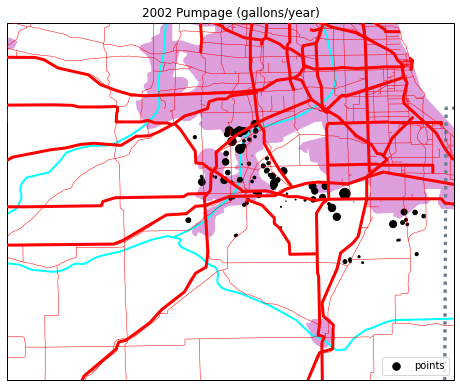

In [11]:
#plotting figure for pumpage data
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xlim(minlong,maxlong)
ax.set_ylim(minlat,maxlat)
ax.set_title("Pumpage (gallons/yr)")

#add geographical features
states_provinces = cf.NaturalEarthFeature(
    category='cultural', # features are categorized as cultural or physical
    name='admin_1_states_provinces', # name of shapefile
    scale='50m', # scale of features
    facecolor='none')	
largerivers = cf.NaturalEarthFeature(
    category='physical',
    name='rivers_lake_centerlines',
    scale='110m', # major rivers
    facecolor='none')
smallrivers = cf.NaturalEarthFeature(
    category='physical',
    name='rivers_lake_centerlines_scale_rank',
    scale='10m', # smaller rivers (still considered major by many/most people)
    facecolor='none')   
smallestrivers = cf.NaturalEarthFeature(
    category='physical',
    name='rivers_north_america',
    scale='10m', # smaller rivers (still considered major by many/most people)
    facecolor='none')   
popplaces = cf.NaturalEarthFeature(
    category='cultural',
    name='urban_areas', # plots municipal boundaries
    scale='10m',
    facecolor='plum') 
interstates = cf.NaturalEarthFeature(
    category='cultural',
    name='roads', # plots municipal boundaries
    scale='10m',
    facecolor='red') 
smallroads = cf.NaturalEarthFeature(
    category='cultural',
    name='roads_north_america', # plots municipal boundaries
    scale='10m',
    facecolor='red') 
# adds the features defined above; zorder allows you to choose the order map is layered
ax.add_feature(popplaces,edgecolor='plum',linewidth=1.0, zorder=1)
ax.add_feature(largerivers,edgecolor='aqua',linewidth=2.0, zorder=2)
ax.add_feature(smallrivers,edgecolor='aqua',linewidth=2.0, zorder=2)
ax.add_feature(smallestrivers,edgecolor='aqua',linewidth=2.0, zorder=2)
ax.add_feature(states_provinces, edgecolor='slategray', linewidth=3.0,linestyle=':', zorder=3)
ax.add_feature(interstates, edgecolor='red', facecolor = '',linewidth=3.0,zorder=3)
ax.add_feature(smallroads, edgecolor='red', facecolor = '',linewidth=0.5,zorder=3)

#create array of pumpage data and adjust accordingly; divided by a number appropriate for map size by trial and error
#when you make scatter plot (below), this allows different sized points to be plotted, related to the magnitude of pumping 
sz=(df2002pump['Pumpage 2002 (gal/yr)'].values/1000000)
print(sz)

#plot map of pumpage data with coordinates
plt.scatter(df2002pump['Latitude'],df2002pump['Longitude'],sz, marker=".", color="black", label="points",zorder=3)
plt.legend(loc='lower right')
plt.fill()
plt.title('2002 Pumpage (gallons/year)')
plt.show()